In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [2]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [4]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [5]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1183 non-null   object 
 1   Close   1183 non-null   float64
 2   Volume  1183 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.9+ KB


**Data Time Period**

In [6]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2023-12-29')

## Visualize the data

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

## Data Preprocessing

In [9]:
df[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Close','Volume']])
scaled_train = scaler.transform(df[['Close','Volume']])
train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [11]:
train_df.head()

,Close,Volume
0,-1.337481,-1.004584
1,-1.310477,-0.215765
2,-1.325174,-0.679115
3,-1.312368,-0.542926
4,-1.297361,-0.336566


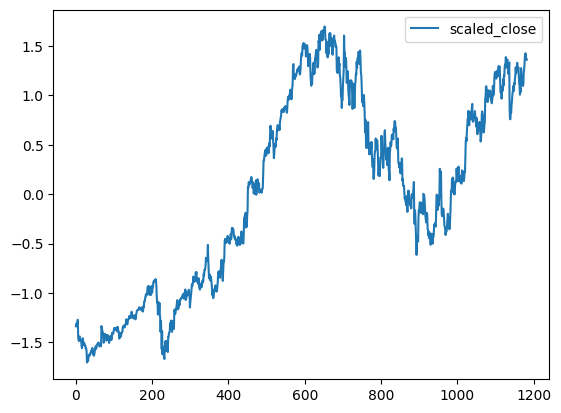

In [12]:
# Visualize scaled data
plt.plot(train_df['Close'], label = 'scaled_close')
plt.legend()
plt.show()

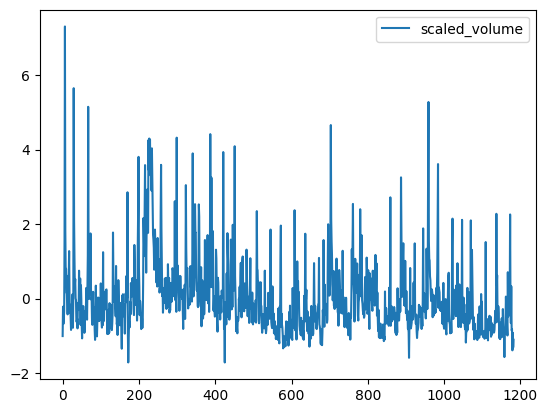

In [13]:
plt.plot(train_df['Volume'], label = 'scaled_volume')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [14]:
# def create_sequences(data, time_steps):
#     num_features = data.shape[1]
#     # Create sequences with time steps
#     sequences = []
#     for i in range(len(data) - time_steps + 1):
#         sequence = data[i:i + time_steps]
#         sequences.append(sequence)

#     # Convert sequences to numpy array
#     sequences = np.array(sequences)

#     # Reshape the array to have dimensions (samples, time steps, features)
#     reshaped_data = sequences.reshape(-1, time_steps, num_features)
#     return reshaped_data

# TIME_STEPS = 30

# X_train, y_train = create_sequences(train, TIME_STEPS) , np.array(train[TIME_STEPS:])
# X_test, y_test = create_sequences(test,TIME_STEPS) ,np.array(test[TIME_STEPS:])


# print("Training input shape: ", X_train.shape)
# print("Testing input shape: ", X_test.shape)

In [15]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  return np.array(Xs), np.array(Ys)

In [16]:
TIME_STEPS = 1
X_train, Y_train= generate_sequences(train_df, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (1182, 1, 2)
Training input shape:  (1182, 1, 2)


In [17]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape.

In [18]:
# model = Sequential()
# model.add(LSTM(128, activation = 'tanh', input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation = 'tanh'))
# model.add(Dropout(rate=0.2))
# model.add(RepeatVector(X_train.shape[1]))
# model.add(LSTM(64, activation = 'tanh', return_sequences=True))
# model.add(LSTM(128, activation = 'tanh', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(X_train.shape[2])))
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()

In [19]:
encoder = Sequential()
encoder.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
encoder.add(LSTM(64, activation='relu'))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential() 
decoder.add(LSTM(64, activation='relu', return_sequences=True))
decoder.add(LSTM(128, activation='relu', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(loss='mae', optimizer='adam')

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
Total params: 116,480
Trainable params: 116,480
Non-trainable params: 0
_________________________________________________________________


In [21]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 2)             258       
 ibuted)                                                         
                                                                 
Total params: 132,098
Trainable params: 132,098
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [22]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
30/30 [==============================] - 10s 57ms/step - loss: 0.8065 - val_loss: 0.7169
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.8013 - val_loss: 0.7146
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.7938 - val_loss: 0.7092
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.7153 - val_loss: 0.7291
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 0.7395 - val_loss: 0.6766
Epoch 6/100
30/30 [==============================] - 0s 13ms/step - loss: 0.5772 - val_loss: 0.6575
Epoch 7/100
30/30 [==============================] - 1s 22ms/step - loss: 0.5180 - val_loss: 0.5660
Epoch 8/100
30/30 [==============================] - 1s 19ms/step - loss: 0.3526 - val_loss: 0.2583
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 0.3995 - val_loss: 0.5256
Epoch 10/100
30/30 [==============================] - 0s 16ms/step - loss: 0.3966 - val_loss: 0.398

#### Plot Training - Validation loss

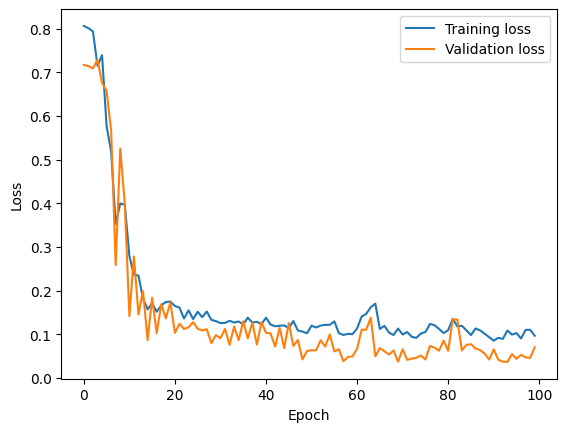

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

37/37 [==============================] - 2s 5ms/step
Reconstruction error threshold for close: 0.27596707257401043
Reconstruction error threshold for volume: 1.7411774728005316


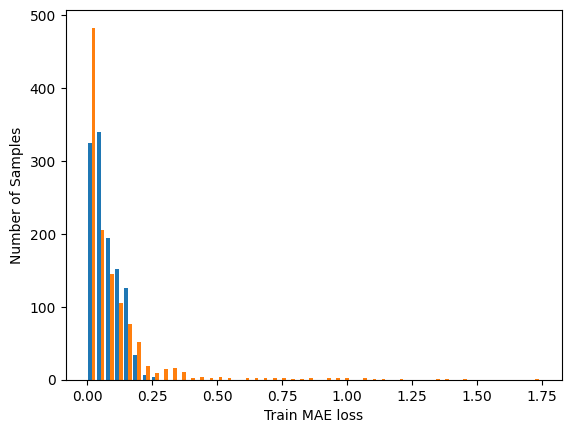

In [24]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

max_values = np.max(train_mae_loss, axis=0)
close_threshold = max_values[0]
volume_threshold = max_values[1]


print('Reconstruction error threshold for close:',close_threshold)
print('Reconstruction error threshold for volume:',volume_threshold)

In [25]:
model.save('saved_models/base_ae_lstm_multi.h5')

## Predict Anomalies on test data using threshold

In [26]:
new_df = pd.read_csv('Stocks\TestAnomaly.csv')
new_df = new_df[['Date','Close','Volume']]
scaled_new_test = scaler.transform(new_df[['Close','Volume']])

X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)
new_mae_loss = np.mean(np.abs(new_test_pred-X_new), axis=1)

8/8 [==============================] - 0s 8ms/step


In [27]:
anomaly_df = new_df[TIME_STEPS:]
print(anomaly_df.head())
print(len(anomaly_df))

       Date       Close      Volume
1  1/3/2024  140.360001  18974300.0
2  1/4/2024  138.039993  18253300.0
3  1/5/2024  137.389999  15433200.0
4  1/8/2024  140.529999  17645300.0
5  1/9/2024  142.559998  19579700.0
225


In [28]:
test_mae_loss_df = pd.DataFrame(new_mae_loss, columns=['Close_Loss','Volume_Loss'])

anomaly_df['Close_Loss'] = np.array(test_mae_loss_df['Close_Loss'])
anomaly_df['Volume_Loss'] = np.array(test_mae_loss_df['Volume_Loss'])
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_10420\4242969946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ragam\AppData\Local\Temp\ipykernel_10420\4242969946.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss
1,1/3/2024,140.360001,18974300.0,0.080726,0.090283
2,1/4/2024,138.039993,18253300.0,0.078257,0.108145
3,1/5/2024,137.389999,15433200.0,0.066327,0.119851
4,1/8/2024,140.529999,17645300.0,0.039329,0.172284
5,1/9/2024,142.559998,19579700.0,0.069559,0.124323


In [29]:
print(test_mae_loss_df['Close_Loss'].max())
print(test_mae_loss_df['Volume_Loss'].max())

114.16081759234106
12.099117438932156


In [30]:
anomaly_df['anomaly'] = np.where((anomaly_df['Close_Loss'] > close_threshold) & (anomaly_df['Volume_Loss'] > volume_threshold), True, False)
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_10420\1775953158.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
1,1/3/2024,140.360001,18974300.0,0.080726,0.090283,False
2,1/4/2024,138.039993,18253300.0,0.078257,0.108145,False
3,1/5/2024,137.389999,15433200.0,0.066327,0.119851,False
4,1/8/2024,140.529999,17645300.0,0.039329,0.172284,False
5,1/9/2024,142.559998,19579700.0,0.069559,0.124323,False


In [31]:
anomaly_df['anomaly'].value_counts()

anomaly
False    215
True      10
Name: count, dtype: int64

In [32]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close_Loss'], name='Close loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Volume_Loss'], name='Volume loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([close_threshold]*len(anomaly_df)), name='Close Threshold'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([volume_threshold]*len(anomaly_df)), name='Volume Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [33]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
119,6/2/2024,157.351433,11332514.29,50.616192,12.099117,True
142,6/25/2024,600.330002,88888880.00,74.671560,5.879232,True
143,6/26/2024,300.639999,88888880.00,114.035656,12.079625,True
168,7/21/2024,490.320719,88888880.00,56.916083,3.366446,True
169,7/22/2024,157.351433,11332514.29,70.897700,5.310669,True


In [34]:
source_data = scaler.inverse_transform(anomaly_df[['Close', 'Volume']])

anomaly_data = scaler.inverse_transform(anomalies[['Close','Volume']])


In [35]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,0], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,0], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [36]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,1], name='Volume'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,1], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()